In [76]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,permutation_test_score,cross_validate,cross_val_score
from scipy import stats
from sklearn.feature_selection import RFE,RFECV, mutual_info_classif,SelectPercentile ,mutual_info_regression,SequentialFeatureSelector
from sklearn.compose import ColumnTransformer 
import seaborn as sns
from sklearn.preprocessing import PowerTransformer,QuantileTransformer,RobustScaler,MinMaxScaler
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC , SMOTE, ADASYN ,RandomOverSampler,SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import  confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score,recall_score
from sklearn.calibration import calibration_curve

In [2]:
df=pd.read_spss('PTScalculatorMLFinal.sav',usecols=['PTS1No2','Age','Sex','ICULOS',
                                                    'GCS','GOSE','SAH','IVH','Pneumo','EDH','SDH','ICH','DSFx','Shift'],
                convert_categoricals=False)

#df['brain_hemo']=df[['SAH','IVH','EDH','SDH','ICH']].sum(axis=1)
#df.loc[df['brain_hemo']>=1,'brain_hemo']=1

columns_name=df.columns.to_list()
columns_name[0]='PTE'
df.columns=columns_name


print(df,'\n',df.isnull().sum())

     PTE   Age  Sex  ICULOS   GCS  GOSE  SAH  IVH  Pneumo  EDH  SDH  ICH  \
0    1.0  38.0  0.0    33.0   5.0   2.0  1.0  0.0     0.0  1.0  1.0  1.0   
1    1.0  30.0  1.0    39.0   7.0   2.0  1.0  0.0     0.0  0.0  0.0  1.0   
2    1.0  26.0  0.0    31.0   6.0   3.0  1.0  0.0     0.0  0.0  0.0  0.0   
3    1.0  30.0  1.0    19.0   4.0   2.0  0.0  0.0     1.0  0.0  1.0  0.0   
4    1.0  41.0  1.0    15.0   8.0   5.0  0.0  0.0     0.0  0.0  0.0  1.0   
..   ...   ...  ...     ...   ...   ...  ...  ...     ...  ...  ...  ...   
723  0.0  14.0  0.0    12.0  11.0   8.0  0.0  0.0     0.0  0.0  1.0  1.0   
724  0.0  38.0  0.0     5.0  13.0   8.0  0.0  0.0     0.0  0.0  0.0  0.0   
725  0.0  33.0  0.0     4.0   5.0   8.0  0.0  0.0     0.0  0.0  0.0  0.0   
726  0.0  30.0  0.0    19.0   6.0   2.0  0.0  0.0     0.0  0.0  0.0  1.0   
727  0.0  24.0  0.0     9.0   9.0   8.0  0.0  0.0     0.0  0.0  0.0  1.0   

     DSFx  Shift  
0     0.0    0.0  
1     0.0    0.0  
2     0.0    0.0  
3     1.0  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PTE     728 non-null    float64
 1   Age     728 non-null    float64
 2   Sex     728 non-null    float64
 3   ICULOS  728 non-null    float64
 4   GCS     728 non-null    float64
 5   GOSE    728 non-null    float64
 6   SAH     728 non-null    float64
 7   IVH     728 non-null    float64
 8   Pneumo  728 non-null    float64
 9   EDH     728 non-null    float64
 10  SDH     728 non-null    float64
 11  ICH     728 non-null    float64
 12  DSFx    728 non-null    float64
 13  Shift   728 non-null    float64
dtypes: float64(14)
memory usage: 79.8 KB


In [4]:
df.describe()

,PTE,Age,Sex,ICULOS,GCS,GOSE,SAH,IVH,Pneumo,EDH,SDH,ICH,DSFx,Shift
count,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000
mean,0.108516,33.824176,0.159341,15.829670,7.035714,5.115385,0.310440,0.119505,0.101648,0.182692,0.292582,0.399725,0.085165,0.104396
std,0.311245,15.601709,0.366245,11.374268,2.335973,2.221660,0.462992,0.324605,0.302393,0.386680,0.455261,0.490179,0.279319,0.305983
min,0.000000,14.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,8.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,30.000000,0.000000,14.000000,7.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,41.000000,0.000000,21.000000,8.000000,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,98.000000,1.000000,90.000000,13.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.columns

Index(['PTE', 'Age', 'Sex', 'ICULOS', 'GCS', 'GOSE', 'SAH', 'IVH', 'Pneumo',
       'EDH', 'SDH', 'ICH', 'DSFx', 'Shift'],
      dtype='object')

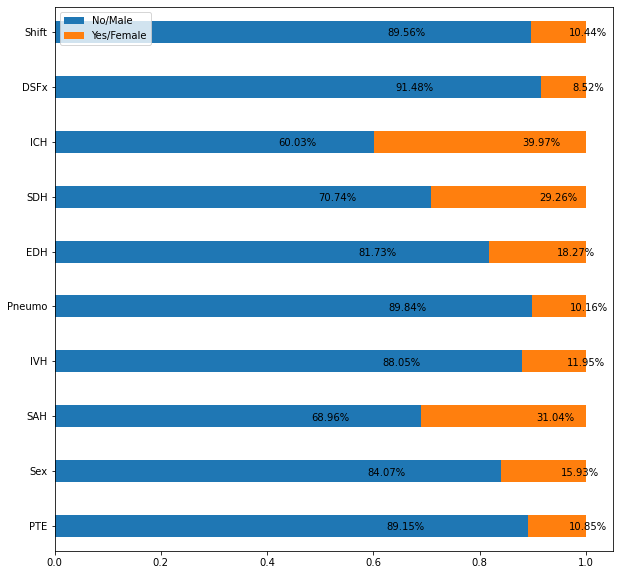

In [6]:
df_desc=df[['PTE', 'Sex', 'SAH', 'IVH', 'Pneumo',
       'EDH', 'SDH', 'ICH', 'DSFx', 'Shift']]

df_stacked = pd.DataFrame({'No/Male':[pd.value_counts(df_desc[i])[0] for i in df_desc.columns.to_list()],
                           'Yes/Female':[pd.value_counts(df_desc[i])[1] for i in df_desc.columns.to_list()]},index=df_desc.columns)

df_stacked_norm=df_stacked.div(df_stacked.sum(axis=1),axis=0)

ax=df_stacked_norm.plot(kind='barh',stacked=True,width=0.4,figsize=(10,10))

for p in ax.patches:
    
    width=p.get_width()
    height=p.get_height()
    x,y=p.get_xy()
    
    plt.text(x+0.7*width , y+0.3*height,f'{width*100:.2f}%')

In [7]:
def train_test(array,test_size,cat_idx,level_of_sig_mann,level_of_sig_chi,level_of_sig_kol):
    list_idxs= []

    def my_filter(x):

        unchosen_idxs = list(set (range(array.shape[0])) - set (x))
        test_array=array[x,:]
        train_array=array[unchosen_idxs,:]

        list_of_distrubition_stat=[]

        for i in range(array.shape[1]):
            
            if i in cat_idx:  # chi_square test to ensure similar distribution in test and train set
                obs=np.array([[(train_array[:,i]==0).sum(),(train_array[:,i]==1).sum()],[(array[:,i]==0).sum(),(array[:,i]==1).sum()]])
                obs2=np.array([[(test_array[:,i]==0).sum(),(test_array[:,i]==1).sum()],[(array[:,i]==0).sum(),(array[:,i]==1).sum()]])
                
                g, p, dof, expctd2 =stats.chi2_contingency(obs)
                g2, p2, dof2, expctd2 = stats.chi2_contingency(obs2)
                
                if p<=level_of_sig_chi or p2<=level_of_sig_chi:
                    list_of_distrubition_stat.append(False)
                    
                else:
                    list_of_distrubition_stat.append(True)
                    
            else: #continious variables
                stat , p = stats.ks_2samp(train_array[:,i],array[:,i])  #2 sample kolmongrov-smirnov test to check distribution similarity
                stat2 , p2 = stats.ks_2samp(array[:,i],test_array[:,i])
                
                if p<=level_of_sig_kol or p2<=level_of_sig_kol:
                    list_of_distrubition_stat.append(False)
                    
                else:
                    statman , pman=stats.mannwhitneyu(train_array[:,i],array[:,i])
                    statman2 , pman2=stats.mannwhitneyu(test_array[:,i],array[:,i])
                    
                    if pman<=level_of_sig_mann or pman2<=level_of_sig_mann:
                        list_of_distrubition_stat.append(False)
                        
                    else:
                        list_of_distrubition_stat.append(True)
                        
        out=np.array(list_of_distrubition_stat)
        
        if np.all(out):
            return True
        
        else:
            return False
        
    for i in range(10000):
        x=np.random.choice(range(array.shape[0]),round(array.shape[0]*test_size),replace=False).tolist()
        list_idxs.append(x)
        
    desired_idxs= filter(  my_filter ,list_idxs)
    
    for i in desired_idxs:
        return array[i,:] , array[list(set (range(array.shape[0])) - set (i)),:]




In [8]:
np.random.seed(42)
test , train = train_test(df.values,0.2,[0,2,6,7,8,9,10,11,12,13],0.25,0.25,0.25)

In [9]:
stats.ks_2samp(train[:,1],df.iloc[:,1].values)

KstestResult(statistic=0.010077980438805182, pvalue=0.9999999999999546)

In [10]:
stats.chi2_contingency(np.array([[(test[:,0]==0).sum(),(test[:,0]==1).sum()],
                                 [df.iloc[:,0].isin([0]).sum(),df.iloc[:,0].isin([1]).sum()]]))

(0.7183802785813393,
 0.3966757215873583,
 1,
 array([[129.46224256,  16.53775744],
        [645.53775744,  82.46224256]]))

In [11]:
print(np.mean(test,axis=0) , np.mean(train,axis=0) , np.mean(df.values,axis=0))

[ 0.1369863  33.20547945  0.17123288 15.56164384  7.17808219  5.15068493
  0.33561644  0.13013699  0.13013699  0.20547945  0.30821918  0.41780822
  0.10958904  0.09589041] [ 0.10137457 33.97938144  0.15635739 15.89690722  7.          5.10652921
  0.30412371  0.11683849  0.09450172  0.17697595  0.28865979  0.395189
  0.0790378   0.10652921] [ 0.10851648 33.82417582  0.15934066 15.82967033  7.03571429  5.11538462
  0.31043956  0.11950549  0.10164835  0.18269231  0.29258242  0.39972527
  0.08516484  0.1043956 ]


In [12]:
train_df=pd.DataFrame(train,columns=df.columns)
train_df

,PTE,Age,Sex,ICULOS,GCS,GOSE,SAH,IVH,Pneumo,EDH,SDH,ICH,DSFx,Shift
0,1.0,38.0,0.0,33.0,5.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,1.0,30.0,1.0,39.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,30.0,1.0,19.0,4.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,1.0,41.0,1.0,15.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,37.0,1.0,20.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,0.0,34.0,0.0,3.0,10.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
578,0.0,28.0,0.0,14.0,6.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
579,0.0,33.0,0.0,4.0,5.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
580,0.0,30.0,0.0,19.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


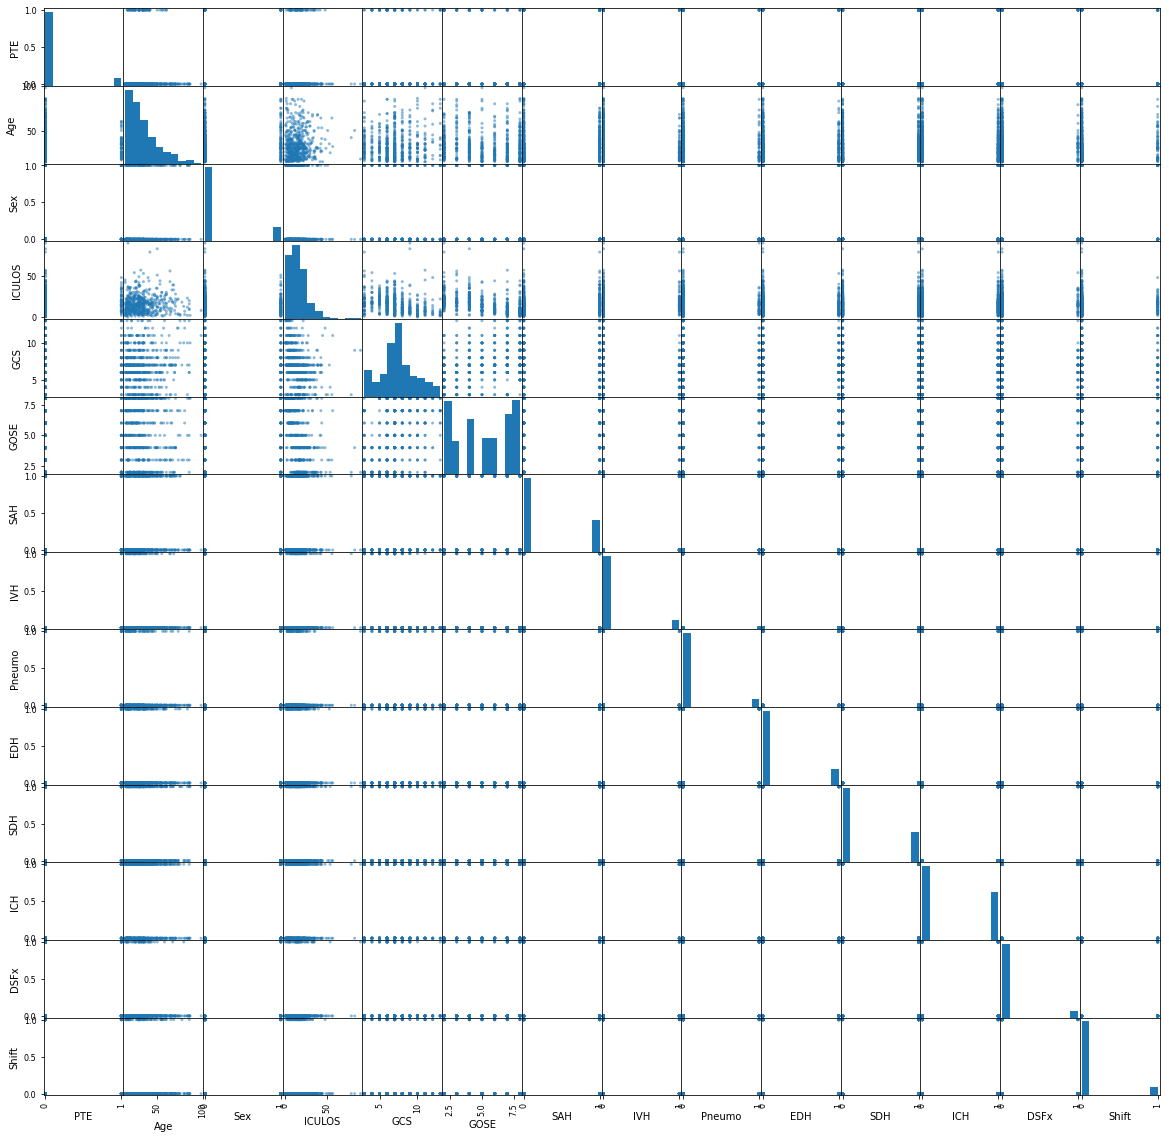

In [13]:
pd.plotting.scatter_matrix(train_df,figsize=(20,20))
plt.show()

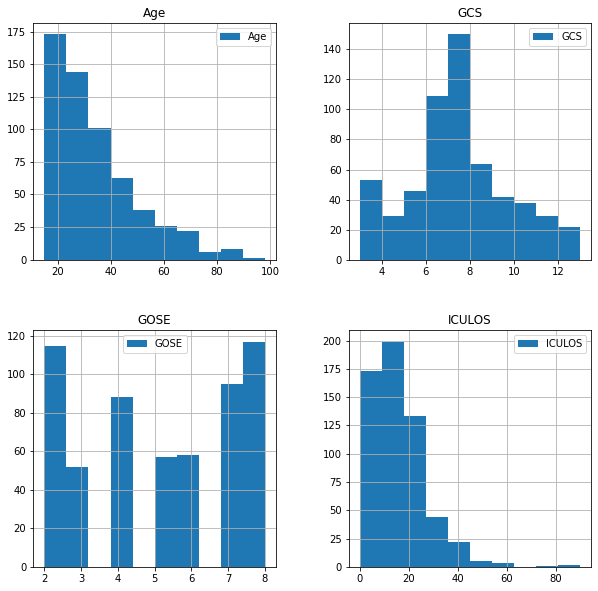

In [14]:
ax=train_df[['Age','GCS','GOSE','ICULOS']].hist(legend=True,figsize=(10,10))
plt.show()

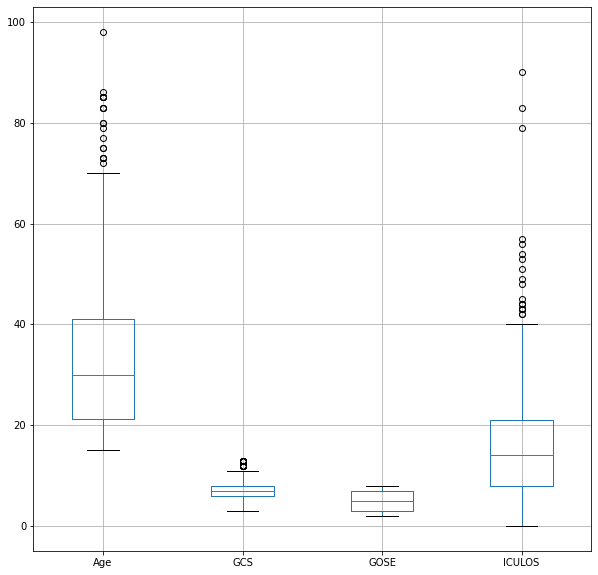

In [15]:
ax=train_df[['Age','GCS','GOSE','ICULOS']].boxplot(figsize=(10,10))
plt.show()

In [16]:
pd.crosstab(train[:,2],train[:,0])

col_0,0.0,1.0
row_0,,
0.0,443,48
1.0,80,11


In [17]:
cat_col={'Sex':2, 'SAH':6, 'IVH':7, 'Pneumo':8,'EDH':9, 'SDH':10, 'ICH':11, 'DSFx':12, 'Shift':13}

for j,i in cat_col.items():
    cross_tab=pd.crosstab(train[:,i],train[:,0])
    odds,p=stats.fisher_exact(cross_tab)
    print(f'odds ratio_{j}:{odds}\tp_value_{j}:{p}')

odds ratio_Sex:1.2690104166666667	p_value_Sex:0.4561165319739451
odds ratio_SAH:1.4116826503923279	p_value_SAH:0.23446219874953145
odds ratio_IVH:1.019546027742749	p_value_IVH:1.0
odds ratio_Pneumo:1.3321314102564104	p_value_Pneumo:0.4824640053249665
odds ratio_EDH:1.6851756198347108	p_value_EDH:0.10680153190130783
odds ratio_SDH:2.285904255319149	p_value_SDH:0.00375963187442881
odds ratio_ICH:1.8025843503230439	p_value_ICH:0.03525261202354671
odds ratio_DSFx:2.364324324324324	p_value_DSFx:0.03879696647859155
odds ratio_Shift:2.7338065661047026	p_value_Shift:0.006228317024701014


In [18]:
train_df.columns

Index(['PTE', 'Age', 'Sex', 'ICULOS', 'GCS', 'GOSE', 'SAH', 'IVH', 'Pneumo',
       'EDH', 'SDH', 'ICH', 'DSFx', 'Shift'],
      dtype='object')

In [19]:
scaler=ColumnTransformer([('continious_trans',RobustScaler(),[0,2,3,4]),
                         ('pass','passthrough',[1,5,6,7,8,9,10,11,12])],
                         remainder='passthrough')
set_config(display='diagram')
scaler

ColumnTransformer(remainder='passthrough',
                  transformers=[('continious_trans', RobustScaler(),
                                 [0, 2, 3, 4]),
                                ('pass', 'passthrough',
                                 [1, 5, 6, 7, 8, 9, 10, 11, 12])])

In [20]:
x_train=train_df.loc[:,train_df.columns[1:]]

In [21]:
x_train=x_train.values
x_train

array([[38.,  0., 33., ...,  1.,  0.,  0.],
       [30.,  1., 39., ...,  1.,  0.,  0.],
       [30.,  1., 19., ...,  0.,  1.,  1.],
       ...,
       [33.,  0.,  4., ...,  0.,  0.,  0.],
       [30.,  0., 19., ...,  1.,  0.,  0.],
       [24.,  0.,  9., ...,  1.,  0.,  0.]])

In [22]:
y_train=train_df.iloc[:,0]
y_train=y_train.values

In [23]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [24]:
rfecv=RFECV(estimator=LogisticRegression(class_weight='balanced'),scoring='balanced_accuracy',cv=skf,n_jobs=8)
rfecv.fit(scaler.fit_transform(x_train),y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=LogisticRegression(class_weight='balanced'), n_jobs=8,
      scoring='balanced_accuracy')

In [25]:
rfecv.ranking_

array([1, 3, 1, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1])

In [26]:
x_train_df=np.array(['Age','ICULOS','GCS', 'GOSE','Sex','SAH', 'IVH', 'Pneumo',
       'EDH', 'SDH', 'ICH', 'DSFx', 'Shift'])

x_train_df

array(['Age', 'ICULOS', 'GCS', 'GOSE', 'Sex', 'SAH', 'IVH', 'Pneumo',
       'EDH', 'SDH', 'ICH', 'DSFx', 'Shift'], dtype='<U6')

In [27]:
def mutual_feature(x,y,cat=list(range(4,13)),n=5):
    return mutual_info_classif(x,y,discrete_features=cat,n_neighbors=n,random_state=42)

In [28]:
for train_index, test_index in skf.split(x_train, y_train):
    
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_f, X_test_f = x_train[train_index], x_train[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    
    x_train_scaled=scaler.fit_transform(X_train_f)
    x_test_scaled=scaler.transform(X_test_f)
    
    percentile=SelectPercentile(mutual_feature,percentile=70)
    x_feat=percentile.fit_transform(x_train_scaled,Y_train)
    
    indices=np.argsort(percentile.scores_)[::-1]
    print(x_feat.shape,x_train_df[indices],'\n\n')

(465, 9) ['ICULOS' 'Age' 'SDH' 'GCS' 'Shift' 'ICH' 'DSFx' 'EDH' 'SAH' 'Pneumo'
 'IVH' 'Sex' 'GOSE'] 


(465, 9) ['GOSE' 'Shift' 'Age' 'ICULOS' 'ICH' 'GCS' 'DSFx' 'SDH' 'EDH' 'SAH'
 'Pneumo' 'Sex' 'IVH'] 


(466, 9) ['GOSE' 'ICULOS' 'SDH' 'Age' 'EDH' 'Shift' 'ICH' 'SAH' 'DSFx' 'IVH'
 'Pneumo' 'Sex' 'GCS'] 


(466, 9) ['Age' 'SDH' 'ICULOS' 'Shift' 'GOSE' 'ICH' 'DSFx' 'EDH' 'GCS' 'SAH' 'Sex'
 'IVH' 'Pneumo'] 


(466, 9) ['ICULOS' 'Shift' 'SDH' 'GOSE' 'DSFx' 'ICH' 'SAH' 'EDH' 'Pneumo' 'Sex'
 'IVH' 'GCS' 'Age'] 




In [29]:
scaler=ColumnTransformer([('continious_trans',RobustScaler(),[0,2,3,4]),
                         ('pass','passthrough',[1,5,6,7,8,9,10,11,12])],
                         remainder='passthrough')
set_config(display='diagram')
scaler

ColumnTransformer(remainder='passthrough',
                  transformers=[('continious_trans', RobustScaler(),
                                 [0, 2, 3, 4]),
                                ('pass', 'passthrough',
                                 [1, 5, 6, 7, 8, 9, 10, 11, 12])])

In [30]:
x_train1=x_train[:,[0,1,2,3,4,5,6,7,8,9,10,11,12]]

In [31]:
def mutual_feature(x,y,cat=list(range(4,13)),n=5):
    return mutual_info_classif(x,y,discrete_features=cat,n_neighbors=n,random_state=42)

In [32]:
clf_log=Pipeline([('scaler',scaler),
                  ('feature_selection',SelectPercentile(mutual_feature,percentile=100)),
                  ('classifier',LogisticRegression(class_weight='balanced'))])

scores=cross_validate(clf_log,x_train1,y_train,
                      cv=skf,n_jobs=8,
                      scoring=('balanced_accuracy','roc_auc','precision','recall','accuracy'),
                      return_train_score=True)

In [33]:
mean_log_train=np.mean(scores['train_balanced_accuracy'])
std_log_train=1.96*np.std(scores['train_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_log_train}+/-{std_log_train}')

mean:0.6851885154222579+/-0.01670245165115473


In [34]:
mean_log_test=np.mean(scores['test_balanced_accuracy'])
std_log_test=1.96*np.std(scores['test_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_log_test}+/-{std_log_test}')

mean:0.6394855144855145+/-0.04137274772180457


In [35]:
clf_log.fit(x_train1,y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('continious_trans',
                                                  RobustScaler(),
                                                  [0, 2, 3, 4]),
                                                 ('pass', 'passthrough',
                                                  [1, 5, 6, 7, 8, 9, 10, 11,
                                                   12])])),
                ('feature_selection',
                 SelectPercentile(percentile=100,
                                  score_func=<function mutual_feature at 0x000001DEE4885AF0>)),
                ('classifier', LogisticRegression(class_weight='balanced'))])

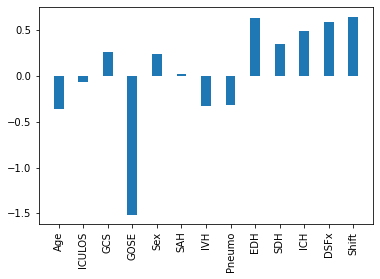

In [36]:
plt.bar(['Age', 'ICULOS', 'GCS', 'GOSE', 'Sex','SAH', 'IVH', 'Pneumo',
       'EDH', 'SDH', 'ICH', 'DSFx', 'Shift'],clf_log['classifier'].coef_.flatten(),width=0.4)
plt.xticks(rotation=90)
plt.show()

In [63]:
score_random, perm_random, pvalue_random = permutation_test_score(
  clf_log ,x_train1, y_train, scoring="balanced_accuracy", cv=skf, n_permutations=100,n_jobs=-1)

In [64]:
pvalue_random

0.009900990099009901

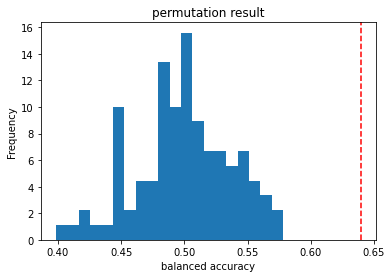

In [65]:
fig, ax = plt.subplots()
ax.hist(perm_random, bins=20, density=True)
ax.axvline(score_random, ls='--', color='r')
plt.xlabel('balanced accuracy')
plt.ylabel('Frequency')
plt.title('permutation result')
plt.show()

In [66]:
clf_svm=Pipeline([('scaler',scaler),
                  ('feature_selection',SelectPercentile(mutual_feature,percentile=100)),
                  ('classifier',svm.SVC(gamma='auto',class_weight='balanced'))])

scores=cross_validate(clf_svm,x_train1,y_train,
                      cv=skf,n_jobs=8,
                      scoring=('balanced_accuracy','roc_auc','precision','recall','accuracy'),return_train_score=True)

In [67]:
mean_svm_train=np.mean(scores['train_balanced_accuracy'])
std_svm_train=1.96*np.std(scores['train_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_svm_train}+/-{std_svm_train}')

mean:0.7608984044436161+/-0.01584703874662671


In [68]:
mean_svm_test=np.mean(scores['test_balanced_accuracy'])
std_svm_test=1.96*np.std(scores['test_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_svm_test}+/-{std_svm_test}')

mean:0.6603946053946055+/-0.06438452245805722


In [69]:
clf_forest=Pipeline([('scaler',scaler),
                  ('feature_selection',SelectPercentile(mutual_feature,percentile=100)),
                  ('classifier',RandomForestClassifier(n_estimators=20,max_depth=20,min_samples_split=20,
                                                       min_samples_leaf=30,random_state=42,class_weight='balanced'))])

scores=cross_validate(clf_forest,x_train1,y_train,
                      cv=skf,n_jobs=8,
                      scoring=('balanced_accuracy','roc_auc','precision','recall','accuracy'),return_train_score=True)

In [70]:
mean_forest_train=np.mean(scores['train_balanced_accuracy'])
std_forest_train=1.96*np.std(scores['train_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_forest_train}+/-{std_forest_train}')

mean:0.7326944201547988+/-0.0090948630035555


In [71]:
mean_forest_test=np.mean(scores['test_balanced_accuracy'])
std_forest_test=1.96*np.std(scores['test_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_forest_test}+/-{std_forest_test}')

mean:0.6007634032634034+/-0.023866867092685314


In [72]:
clf_extra=Pipeline([('scaler',scaler),
                  ('feature_selection',SelectPercentile(mutual_feature,percentile=100)),
                  ('classifier',ExtraTreesClassifier(n_estimators=5,max_depth=5,class_weight='balanced'))])

scores=cross_validate(clf_extra,x_train1,y_train,
                      cv=skf,n_jobs=8,
                      scoring=('balanced_accuracy','roc_auc','precision','recall','accuracy'),return_train_score=True)

In [73]:
mean_extra_train=np.mean(scores['train_balanced_accuracy'])
std_extra_train=1.96*np.std(scores['train_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_extra_train}+/-{std_extra_train}')

mean:0.7949462977801761+/-0.008533779413200488


In [74]:
mean_extra_test=np.mean(scores['test_balanced_accuracy'])
std_extra_test=1.96*np.std(scores['test_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_extra_test}+/-{std_extra_test}')

mean:0.5171969696969697+/-0.058690622692360264


In [53]:
clf_knn=Pipeline([('scaler',scaler),
                  ('feature_selection',SelectPercentile(mutual_feature,percentile=100)),
                  ('classifier',KNeighborsClassifier())])

scores=cross_validate(clf_knn,x_train1,y_train,
                      cv=skf,n_jobs=8,
                      scoring=('balanced_accuracy','roc_auc','precision','recall','accuracy'),return_train_score=True)

In [54]:
mean_knn_train=np.mean(scores['train_balanced_accuracy'])
std_knn_train=1.96*np.std(scores['train_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_knn_train}+/-{std_knn_train}')

mean:0.5429574622367213+/-0.012113693789438757


In [55]:
mean_knn_test=np.mean(scores['test_balanced_accuracy'])
std_knn_test=1.96*np.std(scores['test_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_knn_test}+/-{std_knn_test}')

mean:0.5128296703296703+/-0.019151213082325997


In [ ]:
#بدست اوردن AUC مدل ها
#کشیدن کانفیوژن ماتریس ها
#استفاده از کل فیچرها برای نورال نت
#نحوه انتخاب مدل برای داده تست

In [75]:
clf_log=Pipeline([('scaler',scaler),
                  ('feature_selection',SelectPercentile(mutual_feature,percentile=70)),
                  ('balanced','passthrough'),
                  ('RFE',RFE(LogisticRegression(),n_features_to_select=None)),
                  ('classifier',LogisticRegression(class_weight=None))])

In [76]:
percentile=[20,30,40,50,60,70,80,90,100]
balance=[ADASYN(random_state=42),RandomOverSampler(random_state=42),SMOTE(random_state=42),RandomUnderSampler(random_state=42)]
sampling_strategy=np.linspace(0.2,1,40)
rfe=list(range(1,14))
penalty=['elasticnet']
C=np.linspace(0.1,10,100)
solver=['saga']
l1_ratio=np.linspace(0.1,1,100)

param_clf_log=[{'feature_selection__percentile':percentile,
                'balanced':balance,
                'balanced__sampling_strategy':sampling_strategy,
                'RFE__n_features_to_select':rfe,
                'classifier__penalty':penalty,
                'classifier__C':C,
                'classifier__solver':solver,
                'classifier__l1_ratio':l1_ratio}]

randomized=RandomizedSearchCV(estimator=clf_log,  param_distributions=param_clf_log,  n_iter=5000,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=-1,random_state=42,verbose=4)

In [77]:
randomized.fit(x_train1,y_train)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('continious_trans',
                                                                               RobustScaler(),
                                                                               [0,
                                                                                2,
                                                                                3,
                                                                                4]),
                                                                              ('pass',
                                                                               'passthrough',
                                                                               [1,
                                                                                5,
                                                                                6,
                                                                                7,
                                                                                8,
                                                                                9,
                                                                                10,
                                                                                11,
                                                                                12])])),
                                             ('feature_selection',
                                              SelectPercentile(percentile=70,
                                                               score_func=<function mutual_featu...
       0.82727273, 0.83636364, 0.84545455, 0.85454545, 0.86363636,
       0.87272727, 0.88181818, 0.89090909, 0.9       , 0.90909091,
       0.91818182, 0.92727273, 0.93636364, 0.94545455, 0.95454545,
       0.96363636, 0.97272727, 0.98181818, 0.99090909, 1.        ]),
                                         'classifier__penalty': ['elasticnet'],
                                         'classifier__solver': ['saga'],
                                         'feature_selection__percentile': [20,
                                                                           30,
                                                                           40,
                                                                           50,
                                                                           60,
                                                                           70,
                                                                           80,
                                                                           90,
                                                                           100]}],
                   random_state=42, scoring='balanced_accuracy', verbose=4)

In [78]:
randomized.best_params_

{'feature_selection__percentile': 100,
 'classifier__solver': 'saga',
 'classifier__penalty': 'elasticnet',
 'classifier__l1_ratio': 0.22727272727272727,
 'classifier__C': 7.6,
 'balanced__sampling_strategy': 0.917948717948718,
 'balanced': RandomOverSampler(random_state=42, sampling_strategy=0.917948717948718),
 'RFE__n_features_to_select': 12}

In [79]:
df_randomised_result=pd.DataFrame(randomized.cv_results_)
df_randomised_result.to_csv('param_log.csv')

In [80]:
df_randomised_result.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__percentile,param_classifier__solver,param_classifier__penalty,param_classifier__l1_ratio,param_classifier__C,param_balanced__sampling_strategy,...,param_RFE__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3712,0.056237,7.653546e-03,0.006249,0.007653,100,saga,elasticnet,0.227273,7.6,0.917949,...,12,"{'feature_selection__percentile': 100, 'classi...",0.759524,0.653571,0.669872,0.549679,0.706494,0.667828,0.069382,1
2393,0.062483,4.357259e-06,0.000000,0.000000,100,saga,elasticnet,0.809091,4.8,1.0,...,12,"{'feature_selection__percentile': 100, 'classi...",0.716667,0.680952,0.660256,0.535256,0.682684,0.655163,0.062624,2
3039,0.056237,7.652670e-03,0.006250,0.007655,100,saga,elasticnet,0.881818,7.8,0.897436,...,12,"{'feature_selection__percentile': 100, 'classi...",0.759524,0.616667,0.674679,0.554487,0.661039,0.653279,0.067685,3
3442,0.071858,7.653098e-03,0.000000,0.000000,80,saga,elasticnet,0.454545,8.1,0.917949,...,4,"{'feature_selection__percentile': 80, 'classif...",0.582143,0.605952,0.785256,0.633013,0.658874,0.653048,0.070937,4
446,0.059361,6.248450e-03,0.003124,0.006248,100,saga,elasticnet,0.454545,6.9,1.0,...,11,"{'feature_selection__percentile': 100, 'classi...",0.726190,0.680952,0.623397,0.540064,0.682684,0.650658,0.064223,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,0.081231,6.248999e-03,0.003124,0.006249,90,saga,elasticnet,0.163636,1.3,0.282051,...,3,"{'feature_selection__percentile': 90, 'classif...",0.495238,0.495238,0.500000,0.495192,0.461905,0.489515,0.013928,4996
1609,0.087479,7.652923e-03,0.003124,0.006248,80,saga,elasticnet,0.745455,5.4,0.302564,...,2,"{'feature_selection__percentile': 80, 'classif...",0.500000,0.500000,0.500000,0.475962,0.471429,0.489478,0.012966,4997
770,0.081231,6.248713e-03,0.003124,0.006249,80,saga,elasticnet,0.936364,1.6,0.302564,...,2,"{'feature_selection__percentile': 80, 'classif...",0.500000,0.500000,0.500000,0.475962,0.471429,0.489478,0.012966,4997
1345,0.037965,7.318344e-03,0.000000,0.000000,30,saga,elasticnet,0.981818,4.6,0.302564,...,12,"{'feature_selection__percentile': 30, 'classif...",0.495238,0.495238,0.500000,0.490385,0.461905,0.488553,0.013667,4999


In [183]:
clf_log=Pipeline([('scaler',scaler),
                  ('feature_selection',SelectPercentile(mutual_feature,percentile=100)),
                  ('balanced',RandomOverSampler(random_state=42, sampling_strategy=0.917948717948718)),
                  ('RFE',RFE(LogisticRegression(),n_features_to_select=12)),
                  ('classifier',LogisticRegression(penalty='elasticnet',C=2.01,l1_ratio=0.22727272727272727,solver='saga'))])

scores_log=cross_validate(clf_log,x_train1,y_train,
                      cv=skf,n_jobs=8,
                      scoring=('balanced_accuracy','roc_auc','precision','recall','accuracy'),
                      return_train_score=True,return_estimator=True)

In [184]:
mean_log_train=np.mean(scores_log['train_balanced_accuracy'])
std_log_train=1.96*np.std(scores_log['train_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_log_train}+/-{std_log_train}')

mean:0.6837738284865671+/-0.014248429683089673


In [185]:
mean_log_test=np.mean(scores_log['test_balanced_accuracy'])
std_log_test=1.96*np.std(scores_log['test_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_log_test}+/-{std_log_test}')

mean:0.6649617049617049+/-0.060531845060960224


In [186]:
mean_log_train=np.mean(scores_log['train_roc_auc'])
std_log_train=1.96*np.std(scores_log['train_roc_auc'])/5**(1/2)

print(f'mean:{mean_log_train}+/-{std_log_train}')

mean:0.7508557094016762+/-0.00687436361059185


In [187]:
mean_log_test=np.mean(scores_log['test_roc_auc'])
std_log_test=1.96*np.std(scores_log['test_roc_auc'])/5**(1/2)

print(f'mean:{mean_log_test}+/-{std_log_test}')

mean:0.6821908646908647+/-0.026360205106240427


In [159]:
scores_log

{'fit_time': array([0.03388119, 0.03388119, 0.03291082, 0.0329113 , 0.03390908]),
 'score_time': array([0.004987  , 0.004987  , 0.004987  , 0.004987  , 0.00498652]),
 'estimator': [Pipeline(steps=[('scaler',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('continious_trans',
                                                    RobustScaler(),
                                                    [0, 2, 3, 4]),
                                                   ('pass', 'passthrough',
                                                    [1, 5, 6, 7, 8, 9, 10, 11,
                                                     12])])),
                  ('feature_selection',
                   SelectPercentile(percentile=100,
                                    score_func=<function mutual_feature at 0x000001DEE53418B0>)),
                  ('balanced',
                   RandomOverSampler(random_state=42,
                                

In [87]:
clf_svm=Pipeline([('scaler',scaler),
                  ('feature_selection',SelectPercentile(mutual_feature,percentile=70)),
                  ('balanced','passthrough'),
                  ('RFE',RFE(LogisticRegression(),n_features_to_select=None)),
                  ('classifier',svm.SVC(gamma='auto',class_weight=None))])

In [88]:
percentile=[20,30,40,50,60,70,80,90,100]
balance=[ADASYN(random_state=42),RandomOverSampler(random_state=42),SMOTE(random_state=42),RandomUnderSampler(random_state=42)]
sampling_strategy=np.linspace(0.2,1,40)
rfe=list(range(1,14))
C=np.linspace(0.01,10,20)
kernel=['rbf','linear']
gamma=np.linspace(0,0.7,20)
coef0=np.linspace(0,7,20)

param_svm=[{'feature_selection__percentile':percentile,
            'balanced':balance,
            'balanced__sampling_strategy':sampling_strategy,
            'RFE__n_features_to_select':rfe,
            'classifier__C':C,
            'classifier__kernel':kernel,
            'classifier__gamma':gamma,
            'classifier__coef0':coef0}]

randomized=RandomizedSearchCV(estimator=clf_svm,  param_distributions=param_svm,  n_iter=3000,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=10,random_state=42,verbose=4)

In [89]:
randomized.fit(x_train1,y_train)

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('continious_trans',
                                                                               RobustScaler(),
                                                                               [0,
                                                                                2,
                                                                                3,
                                                                                4]),
                                                                              ('pass',
                                                                               'passthrough',
                                                                               [1,
                                                                                5,
                                                                                6,
                                                                                7,
                                                                                8,
                                                                                9,
                                                                                10,
                                                                                11,
                                                                                12])])),
                                             ('feature_selection',
                                              SelectPercentile(percentile=70,
                                                               score_func=<function mutual_featu...
                                         'classifier__gamma': array([0.        , 0.03684211, 0.07368421, 0.11052632, 0.14736842,
       0.18421053, 0.22105263, 0.25789474, 0.29473684, 0.33157895,
       0.36842105, 0.40526316, 0.44210526, 0.47894737, 0.51578947,
       0.55263158, 0.58947368, 0.62631579, 0.66315789, 0.7       ]),
                                         'classifier__kernel': ['rbf',
                                                                'linear'],
                                         'feature_selection__percentile': [20,
                                                                           30,
                                                                           40,
                                                                           50,
                                                                           60,
                                                                           70,
                                                                           80,
                                                                           90,
                                                                           100]}],
                   random_state=42, scoring='balanced_accuracy', verbose=4)

In [74]:
randomized.best_params_

{'feature_selection__percentile': 50,
 'classifier__kernel': 'rbf',
 'classifier__gamma': 0.03684210526315789,
 'classifier__coef0': 1.4736842105263157,
 'classifier__C': 7.371052631578948,
 'balanced__sampling_strategy': 0.8974358974358974,
 'balanced': ADASYN(random_state=42, sampling_strategy=0.8974358974358974),
 'RFE__n_features_to_select': 10}

In [75]:
df_randomised_result=pd.DataFrame(randomized.cv_results_)
df_randomised_result.to_csv('param_svm.csv')

In [76]:
df_randomised_result.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__percentile,param_classifier__kernel,param_classifier__gamma,param_classifier__coef0,param_classifier__C,param_balanced__sampling_strategy,...,param_RFE__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2111,0.071858,7.652962e-03,0.012497,6.248713e-03,50,rbf,0.036842,1.473684,7.371053,0.897436,...,10,"{'feature_selection__percentile': 50, 'classif...",0.755952,0.764286,0.716346,0.608974,0.639827,0.697077,0.062280,1
377,0.090604,1.169087e-02,0.009373,7.653098e-03,30,rbf,0.589474,1.105263,6.319474,0.979487,...,3,"{'feature_selection__percentile': 30, 'classif...",0.758333,0.661905,0.751603,0.575321,0.646753,0.678783,0.068769,2
47,0.062486,1.518410e-06,0.015620,9.344062e-07,70,rbf,0.073684,4.789474,1.061579,0.753846,...,11,"{'feature_selection__percentile': 70, 'classif...",0.617857,0.765476,0.653846,0.681090,0.636797,0.671013,0.051606,3
2832,0.103101,7.653449e-03,0.006249,7.653195e-03,100,linear,0.0,1.842105,4.216316,0.958974,...,9,"{'feature_selection__percentile': 100, 'classi...",0.679762,0.708333,0.697115,0.581731,0.677922,0.668973,0.045053,4
1652,0.071859,7.652943e-03,0.009373,7.653215e-03,50,rbf,0.147368,1.842105,2.113158,0.958974,...,10,"{'feature_selection__percentile': 50, 'classif...",0.760714,0.704762,0.637821,0.613782,0.616017,0.666619,0.057429,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,0.062486,3.234067e-07,0.012497,6.248355e-03,80,rbf,0.589474,5.157895,8.422632,0.876923,...,10,"{'feature_selection__percentile': 80, 'classif...",0.558333,0.475000,0.451923,0.498397,0.454978,0.487726,0.039027,2996
2310,0.053113,7.653059e-03,0.003124,6.248665e-03,30,rbf,0.221053,4.052632,6.319474,0.323077,...,2,"{'feature_selection__percentile': 30, 'classif...",0.500000,0.500000,0.500000,0.500000,0.438095,0.487619,0.024762,2997
2480,0.090605,1.168976e-02,0.006248,7.652378e-03,100,rbf,0.331579,3.684211,7.896842,0.302564,...,7,"{'feature_selection__percentile': 100, 'classi...",0.495238,0.476190,0.527244,0.461538,0.447619,0.481566,0.027770,2998
296,0.068735,7.653312e-03,0.006248,7.652319e-03,80,rbf,0.515789,0.0,10.0,0.85641,...,12,"{'feature_selection__percentile': 80, 'classif...",0.563095,0.433333,0.447115,0.498397,0.454978,0.479384,0.047173,2999


In [130]:
clf_svm=Pipeline([('scaler',scaler),
                  ('feature_selection',SelectPercentile(mutual_feature,percentile=50)),
                  ('balanced',ADASYN(random_state=42, sampling_strategy=0.8974358974358974)),
                  ('RFE',RFE(LogisticRegression(),n_features_to_select=10)),
                  ('classifier',svm.SVC(kernel='rbf',gamma=0.03684210526315789,coef0=1.4736842105263157,
                                        C=1.9,probability=True))])

scores_svm=cross_validate(clf_svm,x_train1,y_train,
                      cv=skf,n_jobs=8,
                      scoring=('balanced_accuracy','roc_auc','precision','recall','accuracy'),return_train_score=True,
                     return_estimator=True)

In [131]:
mean_svm_train=np.mean(scores_svm['train_balanced_accuracy'])
std_svm_train=1.96*np.std(scores_svm['train_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_svm_train}+/-{std_svm_train}')

mean:0.6875646906692369+/-0.029591677831691848


In [132]:
mean_svm_test=np.mean(scores_svm['test_balanced_accuracy'])
std_svm_test=1.96*np.std(scores_svm['test_balanced_accuracy'])/5**(1/2)

print(f'mean:{mean_svm_test}+/-{std_svm_test}')

mean:0.6637529137529137+/-0.06947427575874988


In [133]:
mean_svm_train=np.mean(scores_svm['train_roc_auc'])
std_svm_train=1.96*np.std(scores_svm['train_roc_auc'])/5**(1/2)

print(f'mean:{mean_svm_train}+/-{std_svm_train}')

mean:0.7499292443432527+/-0.02256263431689258


In [134]:
mean_svm_test=np.mean(scores_svm['test_roc_auc'])
std_svm_test=1.96*np.std(scores_svm['test_roc_auc'])/5**(1/2)

print(f'mean:{mean_svm_test}+/-{std_svm_test}')

mean:0.7009570984570985+/-0.03974385229904747


In [55]:
scores_svm

{'fit_time': array([0.13862991, 0.13464093, 0.14960122, 0.13464069, 0.14561081]),
 'score_time': array([0.01495957, 0.01396251, 0.01595688, 0.01396322, 0.01595759]),
 'estimator': [Pipeline(steps=[('scaler',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('continious_trans',
                                                    RobustScaler(),
                                                    [0, 2, 3, 4]),
                                                   ('pass', 'passthrough',
                                                    [1, 5, 6, 7, 8, 9, 10, 11,
                                                     12])])),
                  ('feature_selection',
                   SelectPercentile(percentile=50,
                                    score_func=<function mutual_feature at 0x000001DEE49783A0>)),
                  ('balanced',
                   ADASYN(random_state=42, sampling_strategy=0.8974358974358974)),
    

In [57]:
u,p=stats.wilcoxon(scores_log['test_balanced_accuracy'],scores_svm['test_balanced_accuracy']
                   ,zero_method='zsplit',mode='auto',alternative='greater')

print(f'wilcoxon:{u}\np-value:{p:.2f}')

wilcoxon:5.0
p-value:0.78


In [58]:
test.shape

(146, 14)

In [59]:
test

array([[ 1., 26.,  0., ...,  1.,  0.,  0.],
       [ 0., 70.,  1., ...,  1.,  0.,  0.],
       [ 0., 26.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0., 60.,  0., ...,  1.,  0.,  0.],
       [ 0., 35.,  0., ...,  1.,  0.,  0.],
       [ 0., 67.,  1., ...,  0.,  0.,  0.]])

In [60]:
y_test=test[:,0]
x_test=test[:,1:]
x_test.shape

(146, 13)

In [61]:
x_test

array([[26.,  0., 22., ...,  1.,  0.,  0.],
       [70.,  1.,  6., ...,  1.,  0.,  0.],
       [26.,  0., 19., ...,  0.,  0.,  0.],
       ...,
       [60.,  0.,  5., ...,  1.,  0.,  0.],
       [35.,  0., 22., ...,  1.,  0.,  0.],
       [67.,  1., 16., ...,  0.,  0.,  0.]])

In [189]:
balanced_log=[]
auc_log=[]
recall_log=[]

for train_index, test_index in skf.split(x_train1, y_train):
    
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_f, X_test_f = x_train1[train_index], x_train1[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    
    clf_log=Pipeline([('scaler',scaler),
                  ('feature_selection',SelectPercentile(mutual_feature,percentile=100)),
                  ('balanced',RandomOverSampler(random_state=42, sampling_strategy=0.917948717948718)),
                  ('RFE',RFE(LogisticRegression(),n_features_to_select=12)),
                  ('classifier',LogisticRegression(penalty='elasticnet',C=2.01,l1_ratio=0.22727272727272727,solver='saga'))])
    
    clf_log.fit(X_train_f,Y_train)
    
    pred=clf_log.predict(x_test)
    
    balanced=balanced_accuracy_score(y_test,pred)
    balanced_log.append(balanced)
    
    auc_scoree=roc_auc_score(y_test,pred)
    auc_log.append(auc_scoree)
    
    recall_scoree=recall_score(y_test,pred,pos_label=0)
    recall_log.append(recall_scoree)
    
balanced_log=np.array(balanced_log)
auc_log=np.array(auc_log)
recall_log=np.array(recall_log)

print(f'mean:{np.mean(balanced_log)}+/-{1.96*np.std(balanced_log)/5**(1/2)}\nmean:{np.mean(auc_log)}+/-{1.96*np.std(auc_log)/5**(1/2)}\nmean:{np.mean(recall_log)}+/-{1.96*np.std(recall_log)/5**(1/2)}')

mean:0.6399999999999999+/-0.012274900618138821
mean:0.64+/-0.012274900618138854
mean:0.7+/-0.01835291883133661


In [158]:
preds=scores_log['estimator'][4].predict(x_test)
print(confusion_matrix(y_test,preds))

[[91 35]
 [ 8 12]]


In [64]:
preds

array([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 0.])

In [103]:
with open('clf_log.sav','wb') as f:
    pickle.dump(clf_log,f)

In [91]:
loaded_model = pickle.load(open('clf_log.sav', 'rb'))

probab=loaded_model.predict_proba(x_test)

C:\anaconda\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RobustScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\anaconda\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator ColumnTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\anaconda\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SelectPercentile from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info ple

In [92]:
probab

array([[0.26038501, 0.73961499],
       [0.55456366, 0.44543634],
       [0.47674095, 0.52325905],
       [0.59096937, 0.40903063],
       [0.58263947, 0.41736053],
       [0.19644642, 0.80355358],
       [0.62206868, 0.37793132],
       [0.66992648, 0.33007352],
       [0.74002517, 0.25997483],
       [0.78680848, 0.21319152],
       [0.72793788, 0.27206212],
       [0.0386421 , 0.9613579 ],
       [0.50320557, 0.49679443],
       [0.87353356, 0.12646644],
       [0.92531868, 0.07468132],
       [0.40638749, 0.59361251],
       [0.65395336, 0.34604664],
       [0.75873109, 0.24126891],
       [0.79288369, 0.20711631],
       [0.35490022, 0.64509978],
       [0.73257284, 0.26742716],
       [0.76086047, 0.23913953],
       [0.4897177 , 0.5102823 ],
       [0.07781246, 0.92218754],
       [0.72822898, 0.27177102],
       [0.3723334 , 0.6276666 ],
       [0.43108046, 0.56891954],
       [0.88040899, 0.11959101],
       [0.50409493, 0.49590507],
       [0.59370316, 0.40629684],
       [0.

In [90]:
x_test[0,:]

array([26.,  0., 22.,  7.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])